Import the required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
#from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np
import pandas as pd
import re

import random
import math
import time

import matplotlib.pyplot as plt
%matplotlib inline

set a seed to enable repeatability of model operation

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
!pip install spacy --upgrade

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)


### download the spacy english vocabulary 

In [ ]:
%%bash
python -m spacy download en


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-06-17 08:06:37.656904: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


restart the notebook before running this step

In [ ]:
spacy_en = spacy.load('en_core_web_sm')


### helper function to tokenize english sentence

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Upload the Quora dataset and store in a dataframe

Pick those records from the .tsv which has all the token -
* id,	qid1,	qid2,	question1,	question2,	is_duplicate

In [ ]:
id	= []
qid1 = []
qid2 = []	
question1 = []	
question2 = []	
is_duplicate = []



with open('/content/quora_duplicate_questions.tsv', 'r' ,errors='ignore', encoding='cp1252') as f_quora:

  i = 0
  j = 0
  for line in f_quora.readlines():
    if i == 0:
      i += 1
      continue

    tok = re.split(r'\t',line)
          
    if len(tok ) == 6:
      #print(len(tok) , tok)
      #assert len(tok)  == 6
      id.append(tok[0].strip())
      qid1.append(tok[1].strip())
      qid2.append(tok[2].strip())
      question1.append(tok[3].strip())
      question2.append(tok[4].strip())
      is_duplicate.append(tok[5].strip())

assert len(id) == len(qid1) == len (qid2) == len(question1) == len(question2) == len(is_duplicate)
 
column_names = ['quoraid' ,	'qid1' ,	'qid2' ,	'question1' ,	'question2'	,'is_duplicate'] 
quoradf = pd.DataFrame(columns = column_names)

quoradf["quoraid"] = id
quoradf["qid1"] = qid1
quoradf["qid2"] = qid2
quoradf["question1"] = question1
quoradf["question2"] = question2
quoradf["is_duplicate"] = is_duplicate

quoradf.head()


,quoraid,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Data cleanup

* remove Nan from question1 and question2 columns

In [ ]:
quoradfq1_clean = quoradf [quoradf.question1.isnull() == False]


In [ ]:
quoradfclean = quoradfq1_clean [quoradfq1_clean.question2.isnull() == False]


In [ ]:
quoradfclean.isna().any(axis=None)

False

In [ ]:
quoradfclean.head()

,quoraid,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
qstn1 = quoradfclean [quoradfclean.question1.isnull() == True]
qstn1

,quoraid,qid1,qid2,question1,question2,is_duplicate


In [ ]:
qstn2 = quoradfclean [quoradfclean.question2.isnull() == True]
qstn2

,quoraid,qid1,qid2,question1,question2,is_duplicate


### Create torchtext.legacy.data Field object for source question and target question

In [ ]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>') 

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>') 

The fields created above are mapped from column headers

| Column header | Variable name |
| --- | --- |
| **question1** | SRC |
| **question2** | TRG |

In [ ]:
fields = [('question1', SRC), ('question2', TRG)]

#### torchtext example object is created from the dataframe object

* using 2 columns from dataframe - question1 , question2
* column header created above

In [ ]:
example = [torchtext.legacy.data.Example.fromlist([quoradfclean.question1[i],quoradfclean.question2[i]], fields) for i in range(quoradfclean.shape[0])] 

#### torchtext dataset is created

* using example and column header created above

In [ ]:
quoraDataset = torchtext.legacy.data.Dataset(example, fields)

### The dataset is split into train and test in the raio of 70:30

In [ ]:
(train, test) = quoraDataset.split(split_ratio=[70, 30] , random_state = random.seed(SEED) )

a sample record from train dataset

In [ ]:
vars(train.examples[15])

{'question1': ['How',
  'can',
  'I',
  'stop',
  'myopia',
  'progression',
  'if',
  'not',
  'reverse',
  'it',
  '?'],
 'question2': ['What', 'is', '6/6', 'myopia', 'vision', '?']}

#### count of train and test dataset

### There are

* **282995** train records
* **121284** test records

In [ ]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of testing examples: {len(test.examples)}")

Number of training examples: 282995
Number of testing examples: 121284


In [ ]:
vars(train.examples[0])

{'question1': ['Does',
  'love',
  'happen',
  'just',
  'once',
  'in',
  'a',
  'lifetime',
  '?'],
 'question2': ['People',
  'say',
  'love',
  'happens',
  'only',
  'once',
  '.',
  'If',
  'it',
  'happens',
  'again',
  ',',
  'will',
  'it',
  'not',
  'be',
  'the',
  'same',
  'as',
  'the',
  'first',
  '?']}

### Build vocabulary of 

* train text for the SRC and TRG field

In [ ]:
SRC.build_vocab(train, min_freq = 2)
TRG.build_vocab(train, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (en) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (en) vocabulary: 40957
Unique tokens in target (en) vocabulary: 37753


### Dump the SRC and TRG vocabulary for later use

In [ ]:
import os, pickle
with open('srcquoratokenizer.pkl', 'wb') as srctokens: 
    pickle.dump(SRC.vocab.stoi, srctokens)

with open('trgquoratokenizer.pkl', 'wb') as trgtokens: 
    pickle.dump(TRG.vocab.stoi, trgtokens)    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create train and test iterator using BucketIterator

* Sort key is set on question1 - the source

In [ ]:
BATCH_SIZE = 64

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size = BATCH_SIZE, 
                                                            sort_key = lambda x: len(x.question1),
                                                            sort_within_batch=True, device = device)




### Encoder class

There are 3 layers in the encoder

* Embedding layer which stores the vocabulary of question 1

* LSTM layer to process the sentence and return the hidden and cell state

* Dropout layer for regularization

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder class

There are 4 layers in the decoder

* Embedding layer which stores the vocabulary of question 2

* LSTM layer to process the TRG sentence and return the output

* Linear layer to process the output returned by LSTM and generate a 1D vector having the size of TRG vocabulary

* Dropout layer for regularization

This class returns 1D vector of prediction and the last hidden and cell state

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### seq2seq class

This is a wrapper class to call the encoder and decoder class 

* The source sentence is supplied to the encoder and the last hidden and cell state is returned.

* This becomes the initial input to the decoder

* In addition first word of the target sentence is passed to the decoder

* In later iterations one word at a time is supplied till the end of the sentence , previous hidden and cell state become input to the decoder.

* The output of each iteration is stored in an array

* In addition a threshhold limit is set to decide whether to pick the max from the output returned by the decoder or the next word of the sentence in the next iteration.

* The loop continues till the end

* The array of output is returned by the seq2seq model


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            #print(hidden.size())
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

### Initialize 

* the hyperparameters

* create encoder and decoder instance

* create instance of seq2seq model

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

### Initialize the weights

* apply the weights to the model

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(40957, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(37753, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=37753, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,873,465 trainable parameters


### create an instance of Adam optimizer

In [ ]:
optimizer = optim.Adam(model.parameters())

### Create an instance of CrossEntropyLoss

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### utility function to train the model

* extract question 1 and question 2 from the batch object and pass it on to model

* reshape the output and calculate the loss between the predicted output question 2 and target question 2 

* aggregate the loss per epoch

* back propagate to adjust the model weights


In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in iterator:
        
        src = batch.question1 #src
        trg = batch.question2 #trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### utility function to evaluate the model

* set the model in evaluation mode and no back propagation

* extract question 1 and question 2 from the batch object and pass it on to model

* reshape the output and calculate the loss between the predicted output question 2 and target question 2 

* aggregate the loss per epoch

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for batch in iterator:

            src = batch.question1 # src
            trg = batch.question2 #trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### run the model on train and test data for 5 epochs

since there are

* **282995** train records
* **121284** test records

the model was run for 4 epochs , each epoch was taking around 45 minutes to run

* the best model weight was saved for evaluating the model


In [ ]:
N_EPOCHS = 5
CLIP = 1
trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'quora-model.pt')

    trainLossList.append(round(train_loss,2))
    valLossList.append(round(valid_loss,2))

    trainAccyList.append(round(math.exp(train_loss),2))
    valAccyList.append(round(math.exp(valid_loss),2))
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 31m 32s
	Train Loss: 4.921 | Train PPL: 137.144
	 Val. Loss: 5.052 |  Val. PPL: 156.401
Epoch: 02 | Time: 31m 34s
	Train Loss: 4.091 | Train PPL:  59.802
	 Val. Loss: 4.779 |  Val. PPL: 119.021
Epoch: 03 | Time: 31m 25s
	Train Loss: 3.768 | Train PPL:  43.274
	 Val. Loss: 4.730 |  Val. PPL: 113.333
Epoch: 04 | Time: 31m 26s
	Train Loss: 3.575 | Train PPL:  35.697
	 Val. Loss: 4.639 |  Val. PPL: 103.431


### A graph of model performance 

1.   Training and testing PPL across different epochs
2.   Training and testing loss across different epochs



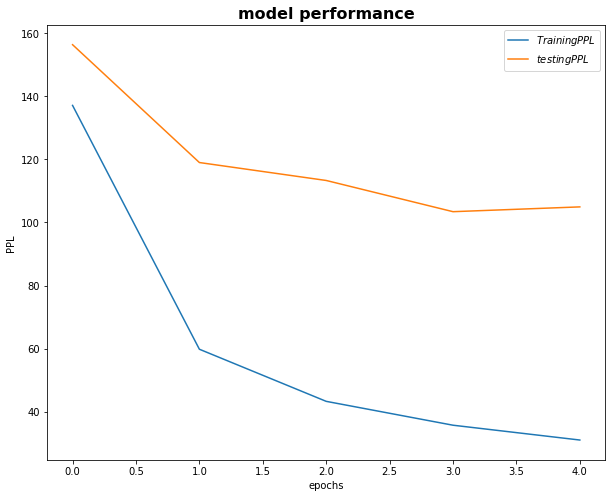

In [43]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training PPL $" )
plt.plot(xpoints, ypoints6, label = "$ testing PPL $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("PPL ")
plt.show()

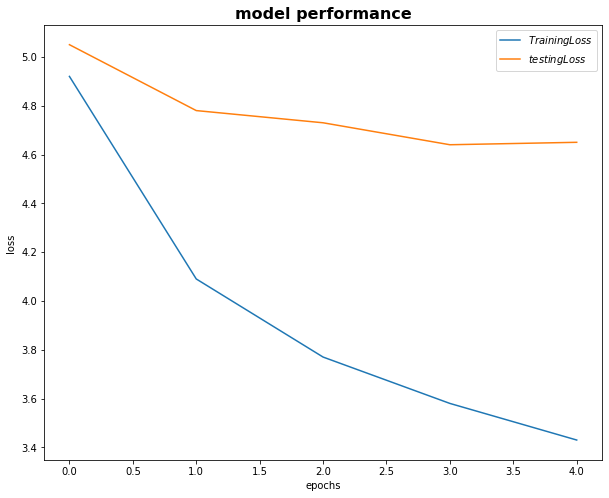

In [44]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ testing Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

In [45]:
model.load_state_dict(torch.load('quora-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.639 | Test PPL: 103.431 |


### Utility function to test a single pair of Question 1 and Question 2

In [46]:
#load weights and tokenizer

#path='./saved_weights.pt'
#model.load_state_dict(torch.load(path));

model.eval();
srctokenizer_file = open('./srcquoratokenizer.pkl', 'rb')
srctokenizer = pickle.load(srctokenizer_file)

trgtokenizer_file = open('./trgquoratokenizer.pkl', 'rb')
trgtokenizer = pickle.load(trgtokenizer_file)


#inference 
#categories = {0: "Negative", 1:"Positive", 2:"Neutral"}

import spacy
nlp = spacy.load('en_core_web_sm')

def answer_question(question , answer):
    
    
    
    # tokenize the tweet 
    srctokenized = [tok.text for tok in nlp.tokenizer(question)] 
    #print(tokenized)
    # convert to integer sequence using predefined tokenizer dictionary
    srcindexed = [srctokenizer[t] for t in srctokenized] 
    #print(indexed)       
    # compute no. of words        
    #length = [len(indexed)]
    # convert to tensor                                    
    srctensor = torch.LongTensor(srcindexed).to(device)   
    #print(tensor)
    # reshape in form of batch, no. of words           
    srctensor = srctensor.unsqueeze(1).T  
    #print(tensor)

    # tokenize the tweet 
    trgtokenized = [tok.text for tok in nlp.tokenizer(answer)] 
    #print(tokenized)
    # convert to integer sequence using predefined tokenizer dictionary
    trgindexed = [trgtokenizer[t] for t in trgtokenized] 
    #print(indexed)       
    # compute no. of words        
    #length = [len(indexed)]
    # convert to tensor                                    
    trgtensor = torch.LongTensor(trgindexed).to(device)   
    #print(tensor)
    # reshape in form of batch, no. of words           
    trgtensor = trgtensor.unsqueeze(1).T  



    # convert to tensor                          
    #length_tensor = torch.LongTensor(length)
    #print(length_tensor)
    # Get the model prediction                  
    prediction = model(srctensor, trgtensor)

    output_dim = prediction.shape[-1]
    #print(output_dim , prediction.size())
            
    output = prediction.squeeze(0)
    #output = output.squeeze(0)

    _, pred = torch.max(output, 1) 
    #print(pred.size(),pred)
    
    return pred #.item()

In [47]:
qst = 'How can I be a good geologist?'
ans =  'What should I do to be a great geologist?'
print(answer_question(qst , ans))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
